# Stadt in Bewegung
## Voruntersuchung der Dimensionen in den Metadaten der Videosammlung "Stadt in Bewegung" auf memobase


In [22]:
##### all imports below (not in specific section)
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from wordcloud import WordCloud 
import numpy as np

### From JSON-Lines to DataFrame

Selected Information from the full record translated into a Pandas Data Frame. 
Included are @id, Date (simplified), duration (as string), Topics (several values), Place (several values), Language (several values).
The titles of the objects are not included. There are 83 objects (0 to 82).


In [23]:
# option setting to show the full length and width of the data frame
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# new empty list to store the extracted data
data = []

# read JSON Lines file
with open('memobase-record-bulk-full.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        try:
            record = json.loads(line)
            
            # Extract the basic fields
            record_data = {
                "@Id": record.get("@id", ""),
                "normalizedDateValue": "",
            }
            
            # Handle created field which might be a dict or list
            created = record.get("created", {})
            if isinstance(created, list):
                # Take the first item if it's a list
                # 8 Elements have 2-3 (successive) years as "created", 
                # for simplicity only the first one is kept here
                created = created[0] if created else {}
            record_data["normalizedDateValue"] = created.get("normalizedDateValue", "")
            
            # Extract duration from the first instantiation
            if "hasInstantiation" in record:
                instantiations = record["hasInstantiation"]
                if isinstance(instantiations, list):
                    for inst in instantiations:
                        if isinstance(inst, dict) and "duration" in inst:
                            record_data["duration"] = inst["duration"]
                            break
                elif isinstance(instantiations, dict) and "duration" in instantiations:
                    record_data["duration"] = instantiations["duration"]
                else:
                    record_data["duration"] = ""
            
            # Extract all the prefLabels from hasOrHadSubject
            if "hasOrHadSubject" in record:
                subjects = record["hasOrHadSubject"]
                if not isinstance(subjects, list):
                    subjects = [subjects] if subjects else []
                
                pref_labels = []
                for subject in subjects:
                    if isinstance(subject, dict) and "prefLabel" in subject:
                        pref_labels.append(subject["prefLabel"])
                
                # Add prefLabels as separate columns
                for i, label in enumerate(pref_labels, 1):
                    record_data[f"prefLabel{i}"] = label
           
            # Extract name from spatial
            if "spatial" in record:
                places = record["spatial"]
                if not isinstance(places, list):
                    places = [places] if places else []
    
                place_names = []
                for place in places:
                    if isinstance(place, dict) and "name" in place:
                        place_names.append(place["name"])
    
            # Add place names as separate columns
            for i, name in enumerate(place_names, 1):
                record_data[f"placeName{i}"] = name

            # Extract name_de from hasOrHadLanguage
            if "hasOrHadLanguage" in record: 
                languages = record["hasOrHadLanguage"]
                if not isinstance(languages, list):  
                    languages = [languages] if languages else []
    
                language_names = []
                for language in languages:
                    if isinstance(language, dict) and "name_de" in language: 
                        language_names.append(language["name_de"])
    
            # Add place names as separate columns
            for i, name_de in enumerate(language_names, 1):
                record_data[f"Language{i}"] = name_de

            data.append(record_data)
            
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
        except Exception as e:
            print(f"Error processing record: {e}")
            print(f"Problematic record: {record}")

# Create DataFrame from the data composed above
df = pd.DataFrame(data)

# Fill NaN values with empty strings for cleaner output
df = df.fillna("")

# Display the whole DataFrame - The DataFrame contains 83 elements
df.head()

# Show full data frame
# df

# The JSONL contains 5 elements without prefLabel
#df[df['prefLabel1'] == ""]

# There are no objects without a placeName
#df[df['placeName1'] == ""]

,@Id,normalizedDateValue,duration,prefLabel1,placeName1,placeName2,Language1,Language2,Language3,Language4,Language5,Language6,prefLabel2,placeName3,placeName4,prefLabel3,prefLabel4,prefLabel5,prefLabel6,prefLabel7,prefLabel8,prefLabel9,placeName5,placeName6,placeName7,placeName8,placeName9,placeName10,placeName11,placeName12,placeName13,placeName14,placeName15,placeName16,placeName17
0,mbr:soz-016-Sozarch_Vid_V_047,1987,01:08:51,Filmkunst,Europa,Schweiz,Italienisch,Russisch,Schweizerdeutsch,Dialekt,Französisch,Deutsch,,,,,,,,,,,,,,,,,,,,,,,
1,mbr:soz-016-Sozarch_Vid_V_026,1988,00:58:10,Kulturpolitik,"Zürich, Stadt","Zürich, Kanton",Schweizerdeutsch,Deutsch,Dialekt,,,,Jugendbewegung,Europa,Schweiz,,,,,,,,,,,,,,,,,,,,
2,mbr:soz-016-Sozarch_Vid_V_035,1983,00:53:00,Kulturindustrie,Baselstadt,"Basel, Stadt",Dialekt,Deutsch,Schweizerdeutsch,,,,Kulturvielfalt,Schweiz,Europa,Recht auf Kultur,Kulturpolitik,Subvention,Kulturförderung,,,,,,,,,,,,,,,,
3,mbr:soz-016-Sozarch_Vid_V_010,1982,00:29:13,Recht auf Kultur,Europa,Schweiz,Deutsch,Schweizerdeutsch,Dialekt,,,,Quartier,"Bern, Stadt","Bern, Kanton",Kulturvielfalt,Jugendbewegung,sozio-kulturelle Einrichtung,,,,,,,,,,,,,,,,,
4,mbr:soz-016-Sozarch_Vid_V_074,1981,00:15:32,Gewalt,Schweiz,"Bern, Kanton",Schweizerdeutsch,Dialekt,,,,,,Europa,,,,,,,,,,,,,,,,,,,,,


# Distribution of the Videos over the Years

The distribution bellow shows most results for the years 1980-1981 and 1986-1988. 51 out of the 83 videos were produced in those years.
In the year 1993 there are no videos in the collection.

A historical exploration of the context could be interesting to explain why those years where particularly active.

For the visualisation a contextualisation of the videos into the events of their production year could give better understanding. This could be done by a query to an AI-API.


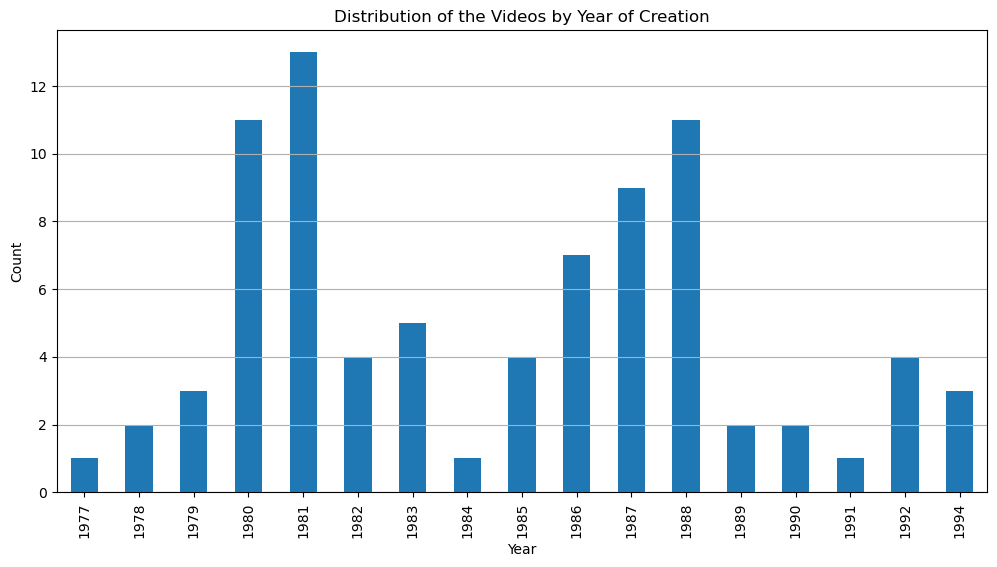

In [24]:
# the column normalizedDateValue contains different formats.
# for elements with several years only one year is kept
#print(df['normalizedDateValue'])

# Extract year from normalizedDateValue if it's in YYYY format
# most dates are in the format YYYY, few in the format YYYY-MM-DD
# create new row with pure YYYY format
df['year'] = df['normalizedDateValue'].str.extract(r'(\d{4})')[0]

# in the new column year all the Dates have the format YYYY as strings
#print(df['year'])

# converting the strings in 'year' to int
df['year'] = df['year'].astype(int)

#testing result by printing the data type
#print(df['year'].dtype)  # Should show 'int32' or 'int64'
#print(df['year'].head())  # Sample values

# Plot bar chart of videos per years
plt.figure(figsize=(12, 6))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of the Videos by Year of Creation')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


# Lenghts of the Videos

The lenght of the Videos is between 00:00:58 to 01:40:20.
Generally spreaking number of videos decreases with growing lenght. 54 Videos are under 30 minutes or around 30 minutes long.
There's also a lot of videos that are just under 1 hour long.

A further investigation could be made into the materiality of the videos to find out, if this has an impact on this.

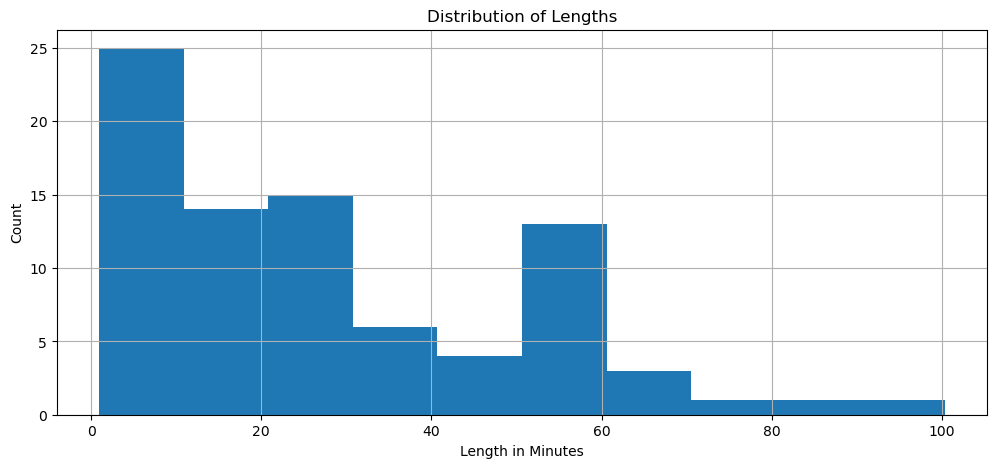

In [25]:
# convert the duration value from string to readable value
def duration_to_seconds(duration_str):
    try:
        if not duration_str:  # Handle empty strings
            return None
        parts = list(map(int, duration_str.split(':')))
        if len(parts) == 3:  # HH:MM:SS
            return parts[0] * 3600 + parts[1] * 60 + parts[2] #1h = 3600 sec, 1 min = 60 sec
        elif len(parts) == 2:  # MM:SS
            return parts[0] * 60 + parts[1]
        else:
            return None
    except:
        return None

# apply the conversion
df['duration_seconds'] = df['duration'].apply(duration_to_seconds)

# Convert to minutes for readability
df['duration_minutes'] = df['duration_seconds'] / 60

# plot histogram of length distribution
plt.figure(figsize=(12, 5))
df['duration_minutes'].hist(bins=10)
plt.title('Distribution of Lengths')
plt.xlabel('Length in Minutes')
plt.ylabel('Count')
plt.show()

# printing all durations
#df['duration_seconds']
#df['duration_minutes']
#df

### Long Data Frame for all topics 

In [26]:
# new dataframe with all subjects in one row but keeping the id and year

# identify all prefLabel columns
pref_label_cols = [col for col in df.columns if col.startswith('prefLabel')]

# adding "_" in prefLabel1 column for the ones that have no value
df.loc[df['prefLabel1'] == "", 'prefLabel1'] = "_"

# Melt the DataFrame to create the long format
long_df = pd.melt(
    df,
    id_vars=['@Id', 'year'],     
    value_vars=pref_label_cols,
    var_name='label_type',
    value_name='prefLabel'
)

# Remove rows where prefLabel is empty
long_df = long_df[long_df['prefLabel'].notna() & (long_df['prefLabel'] != '')]
#keep the elements that have no prefLabel

# Drop the now-unnecessary label_type column
long_df = long_df.drop(columns=['label_type'])

# Reset index for cleanliness
long_df = long_df.reset_index(drop=True)

#print(long_df)


# WordCloud of all the Topics for all Years

The wordclouds show that the dimension of topics could be interesting to explore.

If no underlines are introduced to replace gaps between words the labels are being split. But the result with the split label also shows that there could be more connections with more general tags.

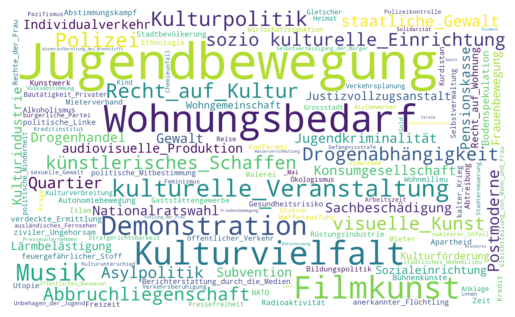

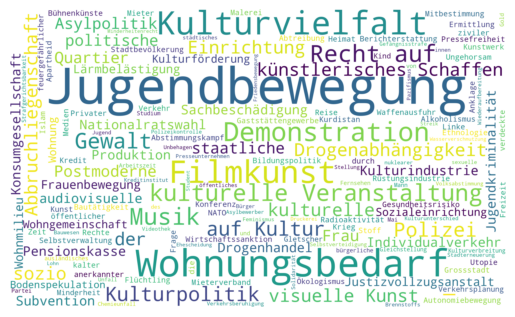

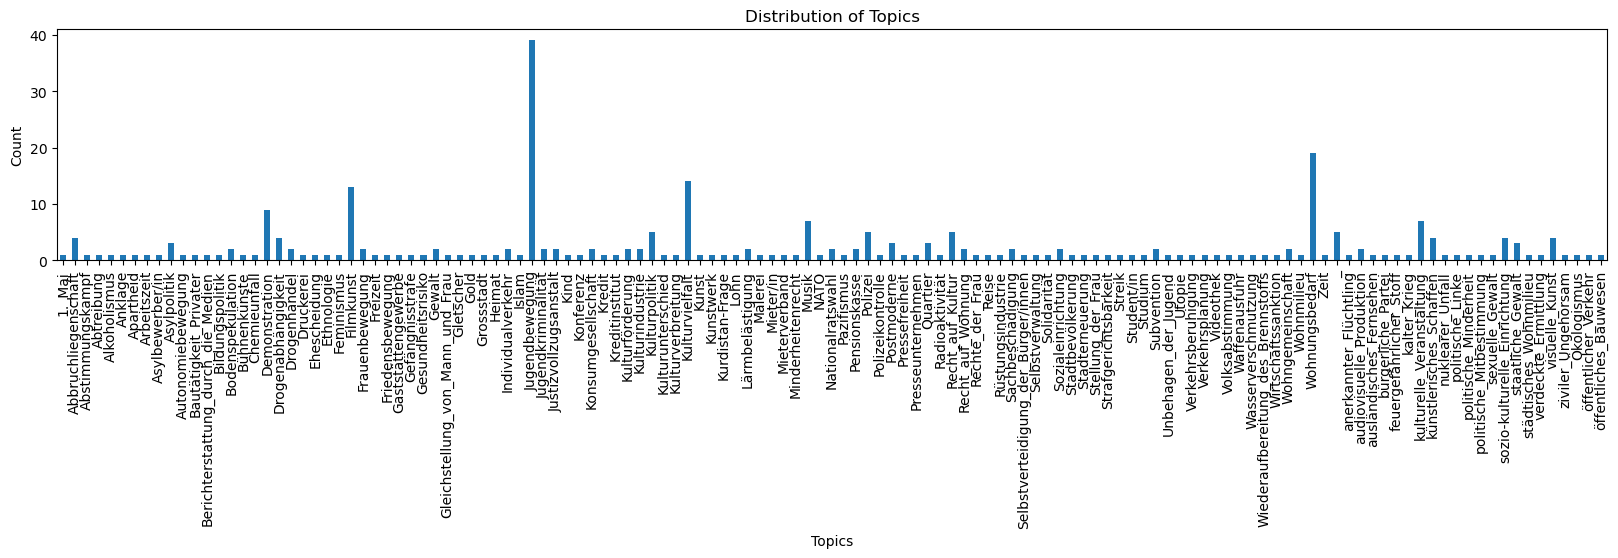

In [27]:
# from the long_df create string for wordcloud and histogram

# Get all prefLabels - as comparision to the version with underlines
all_labels1 = long_df['prefLabel']
all_labels_str1 = ' '.join(all_labels1)

# replacing blanks with underline 
# otherwise split beween words and count is different
long_df['prefLabel'] = long_df['prefLabel'].str.replace(' ', '_')
# Get all prefLabels (excluding empty strings)
all_labels = long_df['prefLabel']
all_labels_str = ' '.join(all_labels)

#all words in prefLabel
#print(all_labels_str)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=2500, height=1500).generate(all_labels_str)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image of the list without underline as comparison
wordcloud = WordCloud(background_color="white", width=2500, height=1500).generate(all_labels_str1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Plot histogram of places
plt.figure(figsize=(20, 3))
long_df['prefLabel'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.show()

# Show Value count of prefLabels 
# print(long_df['prefLabel'].value_counts(ascending=False))

# WordClouds for topics 1980-1981 and 1986-1988

WordClouds for the year ranges 1980-1981 and 1986-1988 - The years with the most videos.

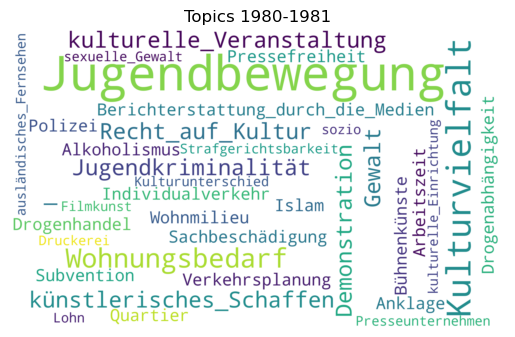

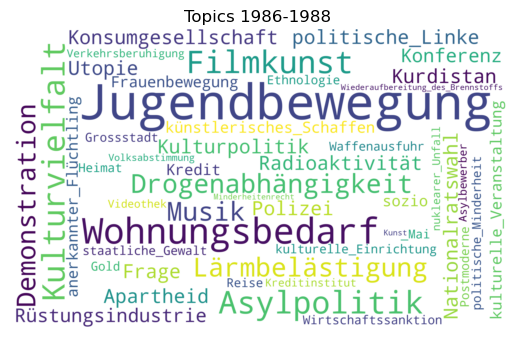

In [28]:
# Filter for only 1981 and 1982
filtered81_df = long_df[long_df['year'].isin([1981, 1982])].copy()
# Filter for only 1986 and 1988
filtered86_df = long_df[long_df['year'].isin([1986, 1988])].copy()

# Select only needed columns
result81_df = filtered81_df[['@Id', 'prefLabel', 'year']].drop_duplicates()
# Select only needed columns
result86_df = filtered86_df[['@Id', 'prefLabel', 'year']].drop_duplicates()

#print(result81_df)

# Get all prefLabels (excluding empty strings)
all_labels81 = result81_df['prefLabel']
all_labels81_str = ' '.join(all_labels81)
# Get all prefLabels (excluding empty strings)
all_labels86 = result86_df['prefLabel']
all_labels86_str = ' '.join(all_labels86)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=2500, height=1500).generate(all_labels81_str)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topics 1980-1981")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=2500, height=1500).generate(all_labels86_str)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topics 1986-1988")
plt.show()


# Mapping the data from the Locations
The metadata about the places contains continents, countries, counties and cities, rivers (in general as well as specific) and mountains (in general as well as specific). For the Sowjet Union years of existance are included and cities appear in several versions.

A visualisation about where the videos where made and what places are mentioned could be interesting. 
But the provided data would need to be cleaned up to make an informative visualisation. Furthermore other aspects are more interesting and give more qualitative insight.

There are some videos with places exclusively not in Switzerland.

What shows is that a lot of videos are made around Basel and Zürich. And not many videos from around Bern are in the collection.

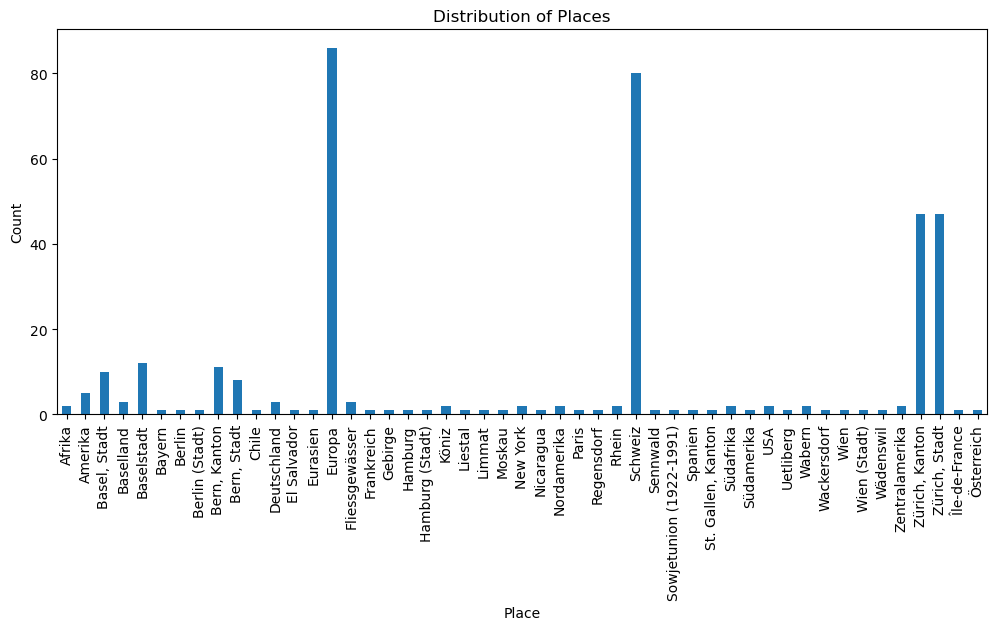

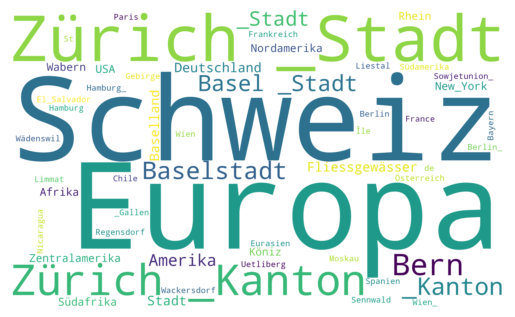

In [29]:
# identify all placeName columns
place_name_cols = [col for col in df.columns if col.startswith('placeName')]

# Melt the DataFrame to create the long format
long_df_places = pd.melt(
    df,
    id_vars=['@Id'],
    value_vars=place_name_cols,
    var_name='label_type',
    value_name='placeName'
)

# Remove rows where placeName is empty
long_df_places = long_df_places[long_df_places['placeName'].notna() & (long_df_places['placeName'] != '')]

# Drop the now-unnecessary label_type column
long_df_places = long_df_places.drop(columns=['label_type'])

# Reset index for cleanliness
long_df_places = long_df_places.reset_index(drop=True)

# Plot chart of places
plt.figure(figsize=(12, 5))
long_df_places['placeName'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Places')
plt.xlabel('Place')
plt.ylabel('Count')
plt.show()

#replacing blanks with underline because it splits word and counts differently
long_df_places['placeName'] = long_df_places['placeName'].str.replace(' ', '_')

# Show the result
#print(long_df_places.tail())

# Get all placeNames (excluding empty strings)
all_places = long_df_places['placeName']
all_places_str = ' '.join(all_places)

#all words in prefLabel
#print(all_labels_str)

#text_wordcoud2 = all_labels_str

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=2500, height=1500).generate(all_places_str)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Relationship Year-Duration
### developpement of the duration of the videos over the years with average trend

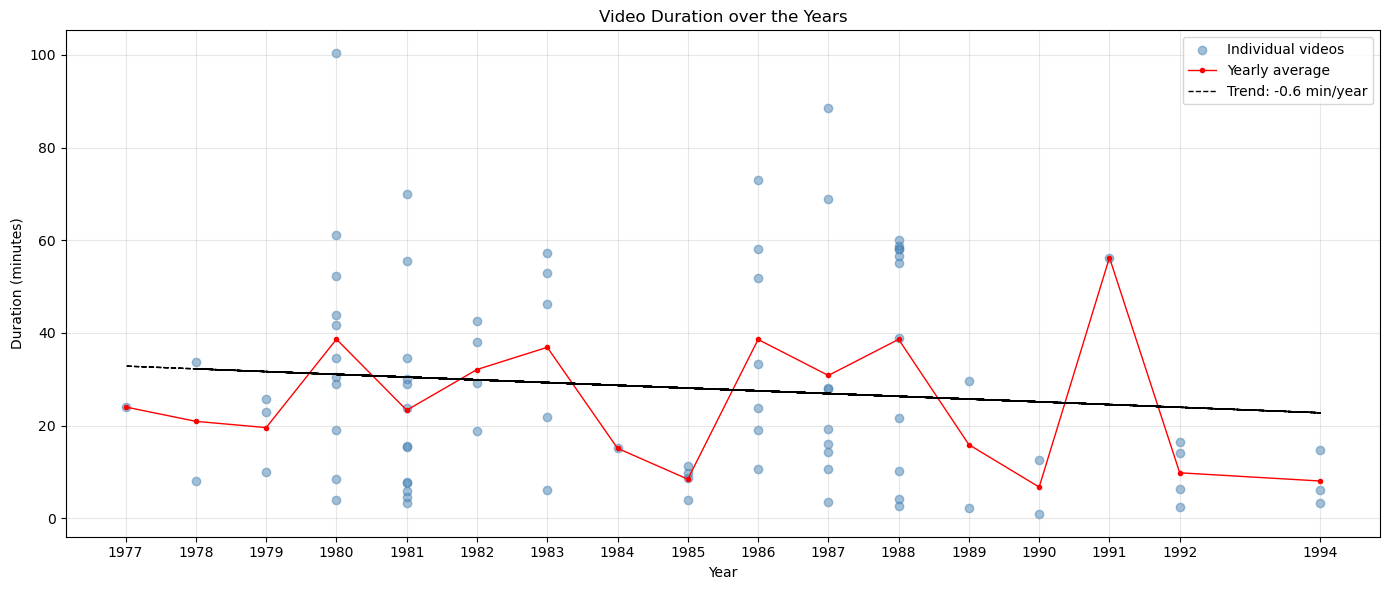

In [30]:
# scatter plot to find out relationship between length and year

# Calculate Averages
yearly_avg = df.groupby('year')['duration_minutes'].mean().reset_index()
overall_trend = np.polyfit(df['year'], df['duration_minutes'], 1)

plt.figure(figsize=(14, 6))

# Scatterplot
plt.scatter(
    x=df['year'],
    y=df['duration_minutes'],
    alpha=0.5,
    color='steelblue',
    label='Individual videos'
)

# Yearly average line (red dots connected)
plt.plot(
    yearly_avg['year'],
    yearly_avg['duration_minutes'],
    'ro-',
    markersize=3,
    linewidth=1,
    label='Yearly average'
)

# Overall trend line (black dashed)
plt.plot(
    df['year'],
    np.polyval(overall_trend, df['year']),
    'k--',
    linewidth=1,
    label=f'Trend: {overall_trend[0]:.1f} min/year'
)

# Force integer years on x-axis
all_years = sorted(df['year'].unique())
plt.xticks(
    ticks=all_years,
    labels=[int(y) for y in all_years]
)

plt.xlabel('Year')
plt.ylabel('Duration (minutes)')
plt.title('Video Duration over the Years')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


# Topics in Videos over the Years
counting all topics (thereby some videos several times) and showing plain occurencies (which means that there are less topics when there are fewer videos)

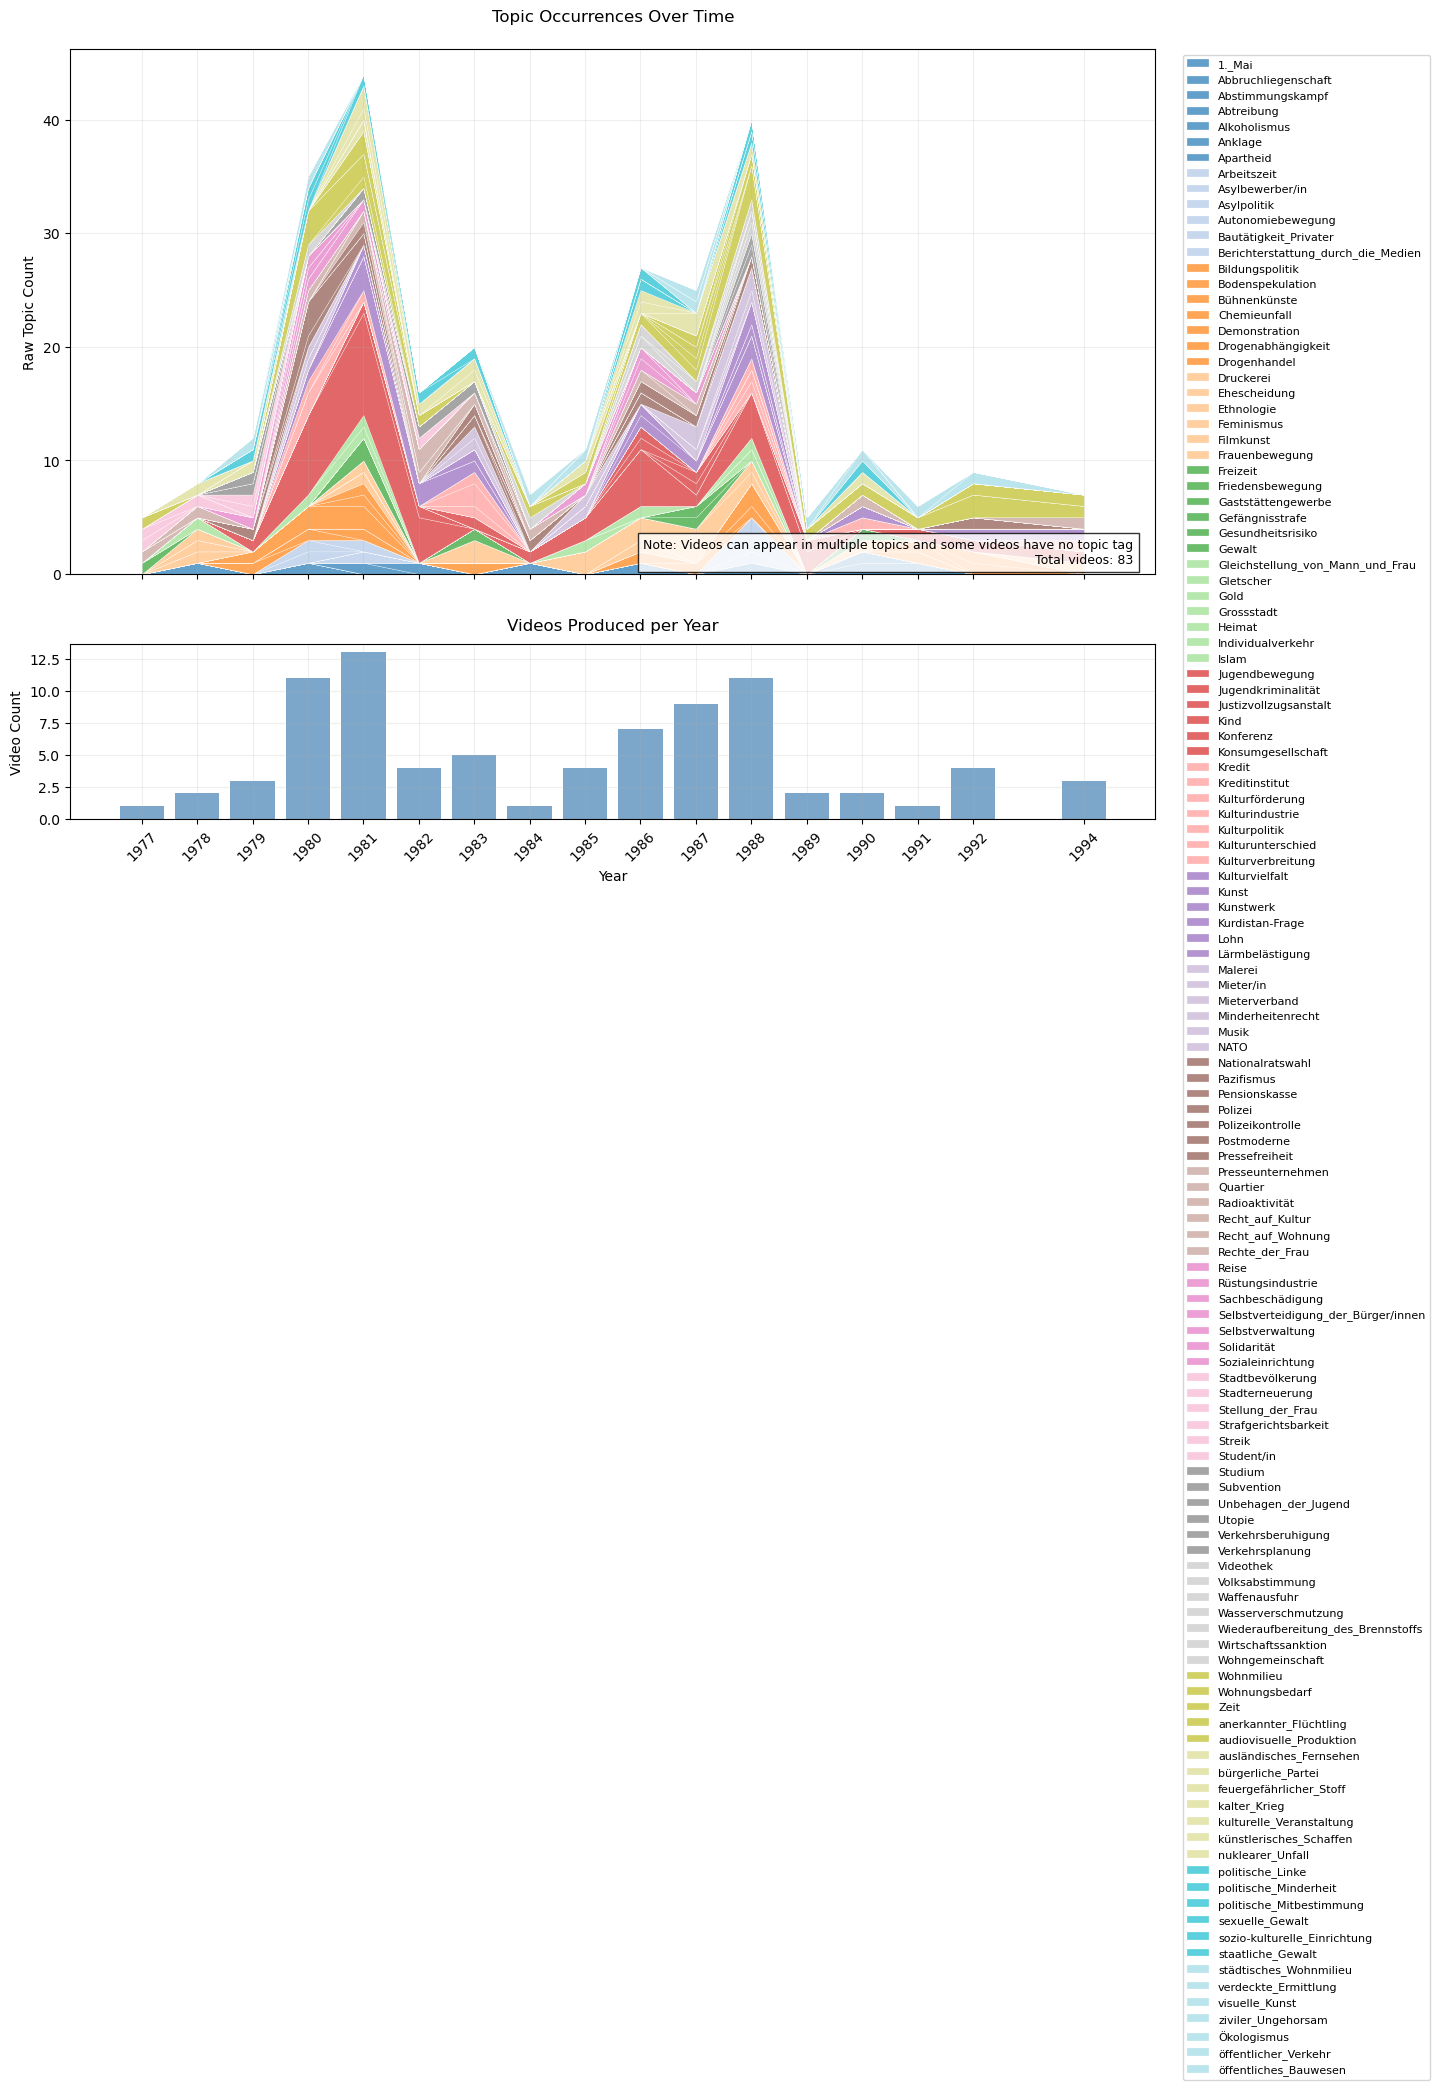

In [31]:
#relationship between year and subject
#long_df contains id, year and subjects (so each video occurs several times)

# Get raw topic counts per year
topic_counts = (
    long_df.groupby(['year', 'prefLabel'])
    .size()
    .unstack()
    .fillna(0)
)

# Count unique videos per year
videos_per_year = (
    long_df[['@Id', 'year']]
    .drop_duplicates()
    .groupby('year')
    .size()
)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 10),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

# Top plot: Stacked topics (raw counts)
colors = plt.cm.tab20(np.linspace(0, 1, len(topic_counts.columns)))
ax1.stackplot(
    topic_counts.index,
    topic_counts.T,
    labels=topic_counts.columns,
    colors=colors,
    alpha=0.7,
    edgecolor='white',
    linewidth=0.3
)
ax1.set_title('Topic Occurrences Over Time', pad=20)
ax1.set_ylabel('Raw Topic Count')
ax1.grid(True, alpha=0.2)
ax1.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=8
)

# Bottom plot: Videos per year (bars)
ax2.bar(
    videos_per_year.index,
    videos_per_year,
    color='steelblue',
    alpha=0.7,
    width=0.8
)
ax2.set_title('Videos Produced per Year', pad=10)
ax2.set_xlabel('Year')
ax2.set_ylabel('Video Count')
ax2.grid(True, alpha=0.2)

# Formatting
years = topic_counts.index.astype(int)
plt.xticks(
    years,
    years,
    rotation=45 if len(years) > 10 else 0
)

# Add text annotation about multi-topics
ax1.text(
    0.98, 0.02,
    f"Note: Videos can appear in multiple topics and some videos have no topic tag\nTotal videos: {len(long_df['@Id'].unique())}",
    transform=ax1.transAxes,
    ha='right',
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()

# Most occuring Topics in Videos over the Years normalized
### normalized by videos per year and by multi-topic videos

In this grafic only the most occuring topics are included. Some videos have a lot of topics registered and some only one. To get a different view of the topic distribution here each video has a weight of one. The topics weight is a fracture that adds up to 1 toghether with the other topics of the video.

What shows as well is that "other" makes up big part. There are a lot of very specific and small ranging topics.

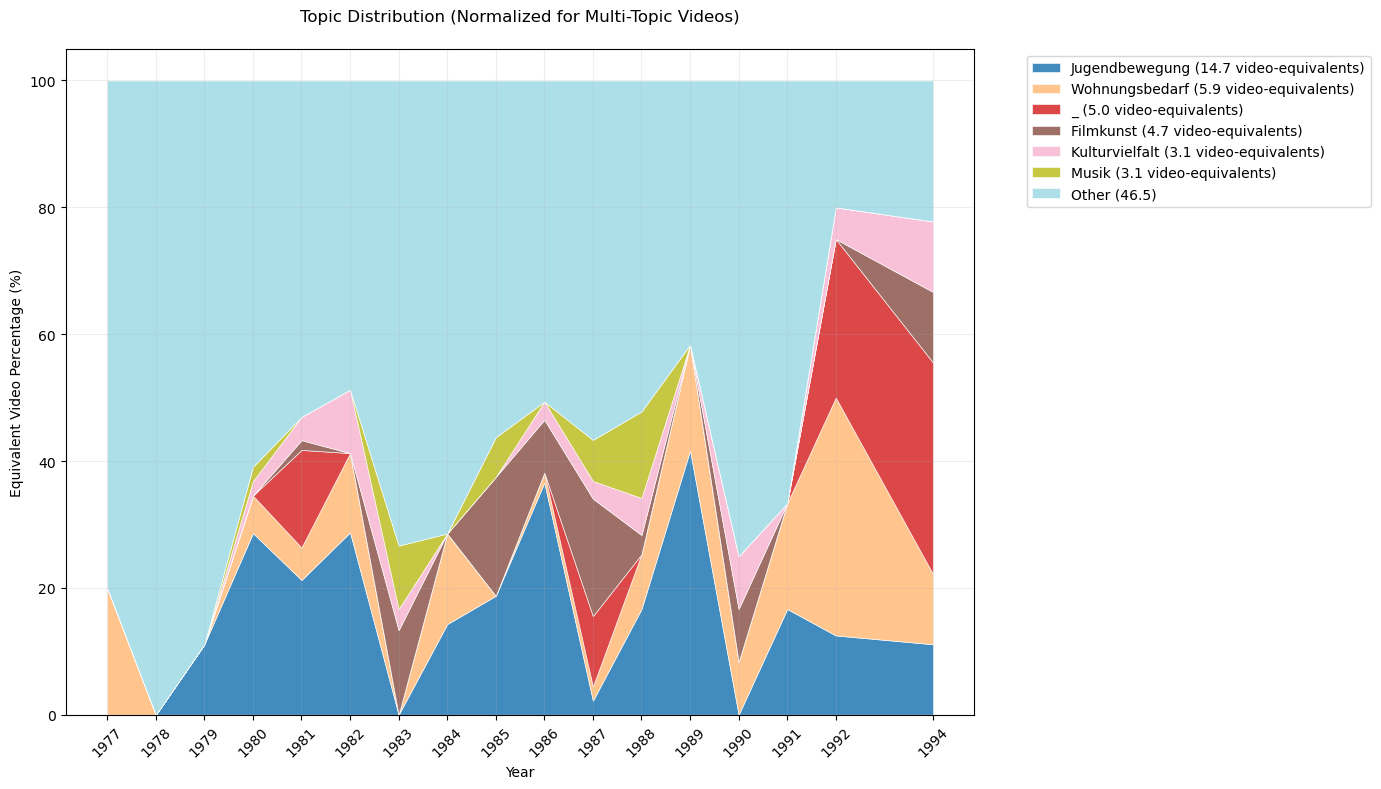

In [32]:
# Stackplot normalized by videos per year and topics per video

# normalize topic weights per video
# Each video's topics sum to 1.0
video_weights = (
    long_df.groupby(['@Id', 'year', 'prefLabel'])
    .size()
    .groupby(['@Id', 'year'])
    .transform(lambda x: 1/len(x))  # Equal weight for each topic in video
    .reset_index()
    .rename(columns={0: 'weight'})
)

# aggregate normalized weights by year and topic
topic_year_weights = (
    video_weights.groupby(['year', 'prefLabel'])
    ['weight'].sum()
    .unstack()
    .fillna(0)
)

# select top 6 topics
top_6 = topic_year_weights.sum().sort_values(ascending=False).head(6).index
other = topic_year_weights.drop(columns=top_6).sum(1)

# normalize as percentage of total videos per year
videos_per_year = long_df[['@Id', 'year']].drop_duplicates().groupby('year').size()
normalized = (topic_year_weights[top_6].T / videos_per_year * 100).T
normalized['Other'] = (other / videos_per_year * 100)

# create and format plot
plt.figure(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 7))

ax = plt.gca()
ax.stackplot(
    normalized.index,
    normalized.T,
    labels=list(top_6) + ['Other'],
    colors=colors,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.5
)

plt.title('Topic Distribution (Normalized for Multi-Topic Videos)', pad=20)
plt.xlabel('Year')
plt.ylabel('Equivalent Video Percentage (%)')
plt.grid(True, alpha=0.2)

legend_labels = [
    f"{topic} ({topic_year_weights[topic].sum():.1f} video-equivalents)"
    for topic in top_6
] + [f"Other ({other.sum():.1f})"]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1))

plt.xticks(
    normalized.index.astype(int),
    normalized.index.astype(int),
    rotation=45 if len(normalized) > 10 else 0
)

plt.tight_layout()
plt.show()

The analysis of the languages had to be omitted due to time constraints.

Furthermore it could be interesting to see the relationship between places and topics through a scatterplot. 

## Aditional Data: Creators and Contributors

This data was added later to look into the fields in the metadata about the people involved in creating the videos.

In [33]:
# new empty list to store the newly extracted data
additionalData = []

with open('memobase-record-bulk-full.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        try:
            record = json.loads(line)
            record_data = {
                "@Id": record.get("@id", ""),
                "publisher": "",
                "creators": "",
                "contributors": ""
            }

            # Try to get publisher from hasPublisher
            publisher = ""
            if "hasPublisher" in record:
                pub = record["hasPublisher"]
                if isinstance(pub, dict) and "name" in pub:
                    publisher = pub["name"]+"1"

            # If not found, try isOrWasRegulatedBy with type "holder"
            if not publisher and "isOrWasRegulatedBy" in record:
                regs = record["isOrWasRegulatedBy"]
                if not isinstance(regs, list):
                    regs = [regs]
                for reg in regs:
                    if isinstance(reg, dict) and reg.get("type", "").lower() == "holder":
                        if "name" in reg:
                            publisher = reg["name"]+"    2"
                            break

            record_data["publisher"] = publisher
            
            # Extract people involved
            creators = []
            contributors = []
            rels = record.get("recordResourceOrInstantiationIsSourceOfCreationRelation", [])
            if not isinstance(rels, list):
                rels = [rels]
            for rel in rels:
                if isinstance(rel, dict):
                    role = rel.get("type", "").lower()
                    target = rel.get("creationRelationHasTarget", {})
                    if isinstance(target, dict):
                        name = target.get("name") or f"{target.get('firstName','')} {target.get('lastName','')}".strip()
                        if role == "creator":
                            creators.append(name)
                        elif role == "contributor":
                            contributors.append(name)
            record_data["creators"] = "; ".join([c for c in creators if c])
            record_data["contributors"] = "; ".join([c for c in contributors if c])

            additionalData.append(record_data)
        except Exception as e:
            print(f"Error: {e}")

adf = pd.DataFrame(additionalData)
adf = adf.fillna("")
adf

,@Id,publisher,creators,contributors
0,mbr:soz-016-Sozarch_Vid_V_047,Dschoint Ventschr Filmproduktion: Zürich1,"Jamal Aldin, Samir","Schär, Astrid; Wahli, Ronnie; Strebel, Lukas; ..."
1,mbr:soz-016-Sozarch_Vid_V_026,Multimedia Photoscene AG: Zürich1,"Rosza, Klaus","Stutz, Heidi; Gränicher, Dieter; Stürzinger, M..."
2,mbr:soz-016-Sozarch_Vid_V_035,Videogenossenschaft Basel1,"Seibt, Thorsten; Manz, Reinhard","Gaçon, Claude; Manz, Reinhard; Gysin, Hans-Rud..."
3,mbr:soz-016-Sozarch_Vid_V_010,"Containter-TV, Bern1","Gasser, Philipp; Aschwanden, Daniel; Bucher, H...",
4,mbr:soz-016-Sozarch_Vid_V_074,"Container-TV, Bern1","Container-TV, Bern",
5,mbr:soz-016-Sozarch_Vid_V_028-1,Videoladen: Zürich1,"Jamal Aldin, Samir (1955-); Schweizer, Werner;...","Vetsch, Christoph; Strebel, Franziska"
6,mbr:soz-016-Sozarch_Vid_V_019,Videogenossenschaft Basel1,Videogenossenschaft Basel,
7,mbr:soz-016-Sozarch_Vid_V_033,Videoladen: Zürich1,Geschichtsladen: Zürich; Lehrlingstreff: Züric...,
8,mbr:soz-016-Sozarch_Vid_V_014,Schweizerisches Sozialarchiv 2,"Jung, Stefan","Sannitz, Mauro; Schaedler, Luc"
9,mbr:soz-016-Sozarch_Vid_V_065,Videogenossenschaft Basel1,"Gaçon, Claude","Giuliani, Hanspeter; Manz, Reinhard"
